In [1]:
# import required libraries
import cv2
import numpy as np 
from matplotlib import pyplot as plt

In [2]:
def imshow(img, figsize=(6, 6)):
    fig, ax = plt.subplots(1, 1, figsize=(figsize))
    ax.axis('off')
    ax.imshow(img)

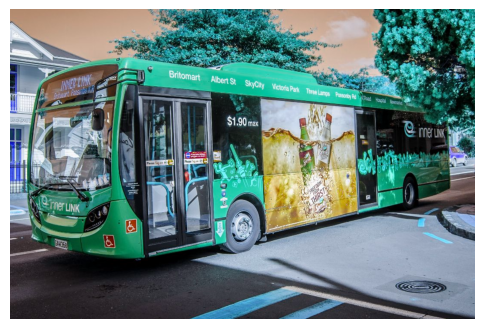

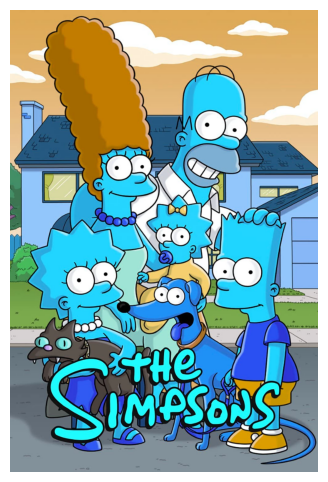

In [21]:
# Names of bus images and Simpsons images
bus_image_path = '../data_input/bus.jpeg'
simpsons_image_path = '../data_input/simpsons.jpeg'

bus_image = cv2.imread('../data_input/bus.jpeg')
simpsons_image = cv2.imread('../data_input/simpsons.jpeg')

# Display image
imshow(bus_image)
imshow(simpsons_image)

In [19]:
# Callback function to determine points on the image
def get_points(event, x, y, flags, param):
    global point_index, points
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
        points[point_index] = (x, y)
        point_index += 1

# Shape bus image
height, width, _ = bus_image.shape

# Initialize the image with the corresponding points
img = bus_image.copy()
points = np.zeros((4, 2), dtype=np.float32)
point_index = 0

# Display the image and wait for the user to identify the point
cv2.imshow('Select Points on Bus Image', img)
cv2.setMouseCallback('Select Points on Bus Image', get_points)

while True:
    cv2.imshow('Select Points on Bus Image', img)
    key = cv2.waitKey(1) & 0xFF
    if point_index == 4 or key == 27:  # Exit when you have determined all 4 points or press Esc
        break

cv2.destroyAllWindows()

# Now we have the corresponding points on the bus image
x1, y1 = points[0]
x2, y2 = points[1]
x3, y3 = points[2]
x4, y4 = points[3]

# Print the specified values
print(f"x1, y1: ({x1}, {y1})")
print(f"x2, y2: ({x2}, {y2})")
print(f"x3, y3: ({x3}, {y3})")
print(f"x4, y4: ({x4}, {y4})")

x1, y1: (584.0, 211.0)
x2, y2: (595.0, 515.0)
x3, y3: (797.0, 229.0)
x4, y4: (807.0, 466.0)


In [22]:
# The function calculates the homography matrix from 4 corresponding points
def calculate_homography(pts1, pts2):
    # Create A matrix
    A = np.zeros((8, 9))
    for i in range(4):
        x, y = pts1[i]
        xp, yp = pts2[i]
        A[2*i] = [-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp]
        A[2*i+1] = [0, 0, 0, -x, -y, -1, x*yp, y*yp, yp]

    # Solve the equation Ax = 0 using SVD
    U, S, Vt = np.linalg.svd(A)
    homography = Vt[-1].reshape(3, 3)

    # Standardization of homography
    homography = homography / homography[2, 2]

    return homography


In [24]:
# converts an image (img) into a 3D tensor (matrix)
def to_mtx(img):
    H,V,C = img.shape
    mtr = np.zeros((V,H,C), dtype='int')
    for i in range(img.shape[0]):
        mtr[:,i] = img[i]
    
    return mtr

# converts a 3D tensor mtr into an image (img) with the same dimensions and format
def to_img(mtr):
    V,H,C = mtr.shape
    img = np.zeros((H,V,C), dtype='int')
    for i in range(mtr.shape[0]):
        img[:,i] = mtr[i]
        
    return img

#  applies a perspective transformation specified by the transformation matrix M to the input image (img)
def warpPerspective(img, M, dsize):
    mtr = to_mtx(img)
    print(mtr)
    R,C = dsize
    dst = np.zeros((R,C,mtr.shape[2]))
    for i in range(mtr.shape[0]):
        for j in range(mtr.shape[1]):
            res = np.dot(M, [i,j,1])
            i2,j2,_ = (res / res[2] + 0.5).astype(int)
            if i2 >= 0 and i2 < R:
                if j2 >= 0 and j2 < C:
                    dst[i2,j2] = mtr[i,j]
    
    return to_img(dst)

[[[224 170  87]
  [224 170  87]
  [224 170  87]
  ...
  [130 145 154]
  [130 145 154]
  [130 145 154]]

 [[224 170  87]
  [224 170  87]
  [224 170  87]
  ...
  [130 145 154]
  [130 145 154]
  [130 145 154]]

 [[224 170  87]
  [224 170  87]
  [224 170  87]
  ...
  [130 145 154]
  [130 145 154]
  [130 145 154]]

 ...

 [[224 170  87]
  [224 170  87]
  [224 170  87]
  ...
  [130 145 154]
  [130 145 154]
  [130 145 154]]

 [[224 170  87]
  [224 170  87]
  [224 170  87]
  ...
  [130 145 154]
  [130 145 154]
  [130 145 154]]

 [[224 170  87]
  [224 170  87]
  [224 170  87]
  ...
  [130 145 154]
  [130 145 154]
  [130 145 154]]]


True

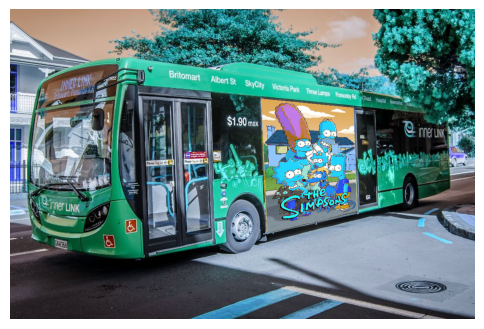

In [26]:
# Define the four corresponding points (manually selected)
# Order: Top-left, Top-right, Bottom-right, Bottom-left
bus_points = np.array([[x, y] for x, y in [(584.0, 208.0), (796.0, 229.0), (805.0, 468.0), (598.0, 518.0)]], dtype=np.float32)
simpsons_points = np.array([[x, y] for x, y in [(0, 0), (simpsons_image.shape[1], 0),
                                                (simpsons_image.shape[1], simpsons_image.shape[0]), 
                                                (0, simpsons_image.shape[0])]], dtype=np.float32)

# Calculate the homographic transformation matrix
b1 = calculate_homography(simpsons_points, bus_points)

# Warp the Simpsons image to fit the Sprite advertisement region on the bus
height, width, _ = bus_image.shape
si = (width, height)
warped_simpsons_1 = warpPerspective(simpsons_image, b1, si)

# Replace the Sprite advertisement region with the warped Simpsons image
result_image_1 = bus_image.copy()
mask_1 = warped_simpsons_1 != 0
result_image_1[mask_1] = warped_simpsons_1[mask_1]

# Display the result
imshow(result_image_1)
cv2.imwrite("../data_output/Transformed_Simpsons_on _Bus.jpeg", result_image_1)

### Using affine transformation

True

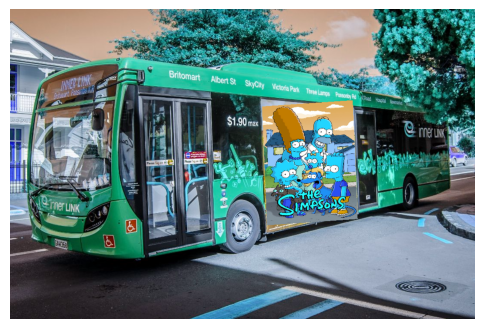

In [35]:
# Defines corresponding points in the source and target images
p1 = np.array([[1, 1], [1000, 1], [1, 1500], [1000, 1500]], dtype=np.float32)
p2 = np.array([[584, 208], [796, 229], [598, 518], [805, 468]], dtype=np.float32)

# Create an affine transformation matrix A
A = np.zeros((8, 6), dtype=np.float32)
for i in range(4):
    x, y = p1[i]
    u, v = p2[i]
    A[2 * i] = [x, y, 1, 0, 0, 0]
    A[2 * i + 1] = [0, 0, 0, x, y, 1]

# Create destination vector B
B = p2.reshape(-1)

# Solve the system of least-squares equations to find the transformation matrix
T = np.linalg.lstsq(A, B, rcond=None)[0]
T = np.append(T, [0, 0, 1])

# Reshape T into a 3x3 affine transformation matrix
T = T.reshape((3, 3))

# Apply transformations to the image
result_affine = bus_image.copy()

for i in range(simpsons_image.shape[1]):
    for j in range(simpsons_image.shape[0]):
        p = np.dot(T, np.array([i, j, 1]))
        p = np.ceil(p).astype(int)
        result_affine[p[1], p[0], :] = simpsons_image[j, i, :]

# Displays the image after applying the transformation
imshow(result_affine)
cv2.imwrite("../data_output/Transformed_Simpsons_on _Bus_.jpeg", result_image_1)